# Analyzing NYC SAT scores

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

In [2]:
# Reading in all the data in dictionary
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
    
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    key_name = f.replace(".csv", "")
    data[key_name] = d

** Let's explore SAT results as it contains information for every high school in New York City **

In [3]:
data["sat_results"].head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


From SAT results data, it seems like `DBN` is unique for each high school. We have scores for for Reading, Writing and Math.

In [4]:
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head(3))


graduation

    Demographic     DBN                            School Name Cohort  \
0  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2003   
1  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2004   
2  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2005   

   Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
0             5               s                         s                 s   
1            55              37                     67.3%                17   
2            64              43                     67.2%                27   

  Total Regents - % of cohort Total Regents - % of grads  \
0                           s                          s   
1                       30.9%                      45.9%   
2                       42.2%                      62.8%   

             ...            Regents w/o Advanced - n  \
0            ...                                   s   
1            ...        

`DBN` is available as column with unique values in every dataframe. This is how, we'll combine all of our datasets into one keeping `DBN` as primary key value. 

** Reading survey data **

Survey data is available in tab delimited formate. Hence, we'll be using encoding value to read it. Once done, let's combine to single dataframe to make it easier to read.

In [5]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding="windows-1252")

survey = pd.concat([all_survey, d75_survey], axis=0)
survey.head(3)

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0


Since there are 2773 columns, let's get only necessary columns based off [data dictionary from download location](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)

In [6]:
# Changing case of dbn to make it easier to merge
survey["DBN"] = survey["dbn"]

# Required columns
columns = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_10", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]

survey= survey.loc[:,columns]
data["survey"] = survey

survey.head(3)

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0


** Cleaning up other data files **

Some of the other data files need to cleaned up as they don't have `DBN` column.

In [7]:
data["class_size"].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN


It can be seen that `DBN` column can be created by combining `CSD` and `SCHOOL CODE` columns.

In [8]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def padded_csd(num):
    string_num = str(num)
    if len(string_num) > 1:
        return string_num
    else:
        return "0" + string_num
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(padded_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

data["class_size"].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015


** Combining all the 3 SAT scores to one **

In [9]:
# Using pandas.to_numeric to convert values to numeric 
courses = ["SAT Math Avg. Score", "SAT Critical Reading Avg. Score", "SAT Writing Avg. Score"]

for c in courses:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"][courses[0]] + data["sat_results"][courses[1]] + data["sat_results"][courses[2]]

data["sat_results"]["sat_score"].head(3)

0    1122.0
1    1172.0
2    1149.0
Name: sat_score, dtype: float64

** Getting coordinates for each school for maps **

In [10]:
import re

def get_latitude(address):
    lat_long =  re.findall("\(.+, .+\)", address)
    return lat_long[0].split(", ")[0].replace("(", "")
    
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(get_latitude)

def get_longitude(address):
    lat_long =  re.findall("\(.+, .+\)", address)
    return lat_long[0].split(",")[1].replace(")", "").strip()
    
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(get_longitude)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

data["hs_directory"].head(3)

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414,-73.916162


## Combining all the datasets

Since data clean up is done, we can start combining all the datasets into one by keeping `DBN` as unique column.

** Condensing class_size **

`class_size` dataset has multiple rows for same school based on `GRADE`, `PROGRAM TYPE` etc. We can get rid of lot of rows as we are only interested in in grades 9 through 12 and where type is Gen Ed.

In [11]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size.head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292


`DBN` value is still not unique due to `CORE SUBJECT` columns. These two columns hold values for different core subjects offered. Let's take average across all the classes a school offers. This will give us unique `DBN` values, but also incorporate as much data as possible into the average

In [12]:
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["class_size"].head(3)

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0,4.0,22.564286,18.5,26.571429,NaN
1,01M332,1,46.0,2.0,22.000000,21.0,23.500000,NaN
2,01M378,1,33.0,1.0,33.000000,33.0,33.000000,NaN


** Condensing demographics **

In order to get unique values for `DBN`, we can get rid of other rows except for school year `20112012`. This will match up with our SAT results data.

In [13]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
data["demographics"].head(3)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3


** Condensing Graduation **

Similar to demographics dataset, here we will pick the most recent available data for full cohort.

In [14]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

data["graduation"].head(3)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%


Finally, let's convert AP scores data to `numeric` for easy comparison afterwards.

In [15]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
data["ap_2010"].head(3)

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0


** Merging all the datasets by performing joins **

AP scores and Graduation data may have missing DBN values, hence we perform `left` join with SAT results so as to retain `DBN` values.

In [16]:
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

combined.head(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%


Since class size, demographics, survey and high school data have important information which we don't want to loose, we'll use `inner` join to combine them.

In [17]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined.head(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041


Filling in missing data due to `left` join with averages.

In [18]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

combined.head(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041


In [19]:
# Creating a district column to further help with our survey
def get_first_2_chars(name):
    return name[:2]
    
combined["school_dist"] = combined["DBN"].apply(get_first_2_chars)
combined["school_dist"].head(3)

0    01
1    01
2    01
Name: school_dist, dtype: object

## Analyzing the data

Since most of the data has been cleaned and combined into single dataframe, let's start analyzing it.


** Finding correlations for SAT scores **

Correlations would tell us how closely related 2 columns are. Since we are interested in SAT scores, we can look at `rvalue` over various factors.

In [20]:
correlations = combined.corr(method="pearson")
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Based off above correlation data, we can safely say that individual test subject scores correlates positively with overall SAT scores, which in general should be the case.

Some of the other conclusions could be - 
- Total enrollment has poitive correlation to SAT scores --> ** bigger schools tend to be better at SAT scores **.
- Percentage and number of females correlates positive to SAT scores while it is inverse for males --> ** Women do better on SAT than men **.
- Significant racial inequality for SAT scores --> ** Asians score more compared to Blacks, Hispanic **.
- English language learners correlate negatively.
- Teacher's and student's safety rating correlates with SAT score along with rated academic standards.

** Let's look at total enrollment **

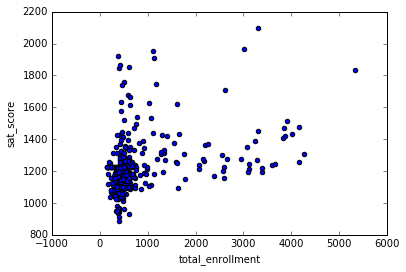

In [21]:
combined.plot.scatter(x="total_enrollment", y="sat_score")
plt.show()

For a positive corelattion (~0.37), plot doesn't show linearly. We can look at bottom left part of plot where values are low, yet there's a cluster formed.

We can extract the name of schools to look into this deeply.

In [22]:
low_enrollment = combined[combined["total_enrollment"] < 1000]
low_enrollment = combined[combined["sat_score"] < 1000]

low_enrollment["School Name"]

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

Simple Google search on each school would let us know that most of the above ones are located in Brooklyn, NY and have high percentage of English language learners enrolled.

Let's plot out English learners percentage to that of SAT scores.

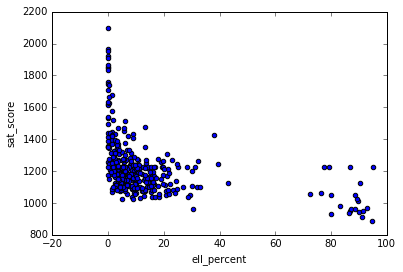

In [23]:
combined.plot.scatter(x="ell_percent", y="sat_score")
plt.show()

As this plot is more linear, we can say that corelation of `ell_percent` to SAT score conforms to positive value. There's still a cluster of low SAT score and high English language learner.

We can map out these on a district level to see which part of city has high numbers.

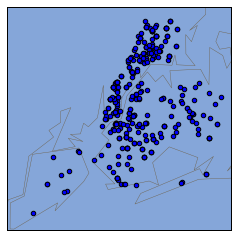

In [24]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True)
plt.show()

We can display more information of English language learners by area, especially shading points corresponding to higher or lower numbers.

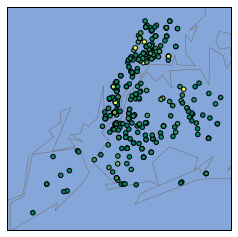

In [25]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")
plt.show()

Above plot is still difficult to read to make any conclusion. In order to make it simple, one way would be to aggregate values based on district.

In [27]:
districts = combined.groupby(combined["school_dist"]).agg(np.mean)

districts.reset_index(inplace=True)
districts.head(3)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370


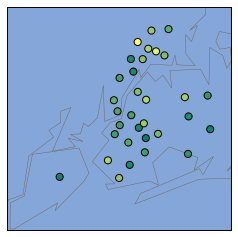

In [28]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")
plt.show()